# Курсовая работа № 2
## Аналитика. Начальный уровень

Курсовая работа состоит из двух частей – обязательной и дополнительной. **Для зачета необходимо выполнение только первой части.** Выполнение второй части может потребовать дополнительные знания Python.

- [Часть первая](#Часть-первая)
- [Часть вторая](#Часть-вторая)



Перед вами стоит задача – подготовить аналитический отчет для HR-отдела. На основании проведенной аналитики предполагается составить рекомендации для отдела кадров по стратегии набора персонала, а также по взаимодействию с уже имеющимися сотрудниками.
<br><br> В базе данных лежит набор таблиц, которые содержат данные о сотрудниках вымышленной компании.
Сделайте обзор штата сотрудников компании. Составьте набор предметов исследования, а затем проверьте их на данных. Вся аналитика должна быть выполена с помощью SQL. Впоследствии данные можно визуализировать, однако финальные датафреймы для графиков также должны быть подготовлены с помощью SQL. <br><br>

Примеры гипотез:
1. Есть зависимость между `perfomance score` и тем, под чьим руководством работает сотрудник.
2. Есть зависимость между продолжительностью работы в компании и семейным положением сотрудника.
2. Есть зависимость между продолжительностью работы в компании и возрастом сотрудника.

<br><br>
Параметры для подключения следующие: хост – `dsstudents.skillbox.ru`, порт – `5432`, имя базы данных – `human_resources`, пользователь – `readonly`, пароль – ``. Таблицы, доступные для анализа, – `hr_dataset`, `production_staff`, `recruting_costs`, `salary_grid`.

In [3]:
import psycopg2
import pandas as pd
import sqlite3
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.rcParams['figure.figsize'] = (10,10)
import numpy as np

pg_connection = {
    "host": "dsstudents.skillbox.ru",
    "port": 5432,
    "dbname": "human_resources",
    "user": "",
    "password": ""
}
conn = psycopg2.connect(**pg_connection)

cursor = conn.cursor()

# получаем имена таблиц из базы
sql_str = "SELECT table_name FROM information_schema.tables WHERE table_schema='public';"
cursor.execute(sql_str)
tables_data = [a for a in cursor.fetchall()]
conn.commit()

#print("Какие таблицы содержатся в Postgres: %s" % tables_data)

df = pd.read_sql_query("select * from public.hr_dataset;", conn)
df



,id,Employee Name,Employee Number,marriedid,maritalstatusid,genderid,empstatus_id,deptid,perf_scoreid,age,...,Date of Hire,Days Employed,Date of Termination,Reason For Term,Employment Status,department,position,Manager Name,Employee Source,Performance Score
0,1,"Brown, Mia",1103024456,1,1,0,1,1,3,30,...,2008-10-27,3317,None,N/A - still employed,Active,Admin Offices,Accountant I,Brandon R. LeBlanc,Diversity Job Fair,Fully Meets
1,2,"LaRotonda, William",1106026572,0,2,1,1,1,3,34,...,2014-01-06,1420,None,N/A - still employed,Active,Admin Offices,Accountant I,Brandon R. LeBlanc,Website Banner Ads,Fully Meets
2,3,"Steans, Tyrone",1302053333,0,0,1,1,1,3,31,...,2014-09-29,1154,None,N/A - still employed,Active,Admin Offices,Accountant I,Brandon R. LeBlanc,Internet Search,Fully Meets
3,4,"Howard, Estelle",1211050782,1,1,0,1,1,9,32,...,2015-02-16,58,2015-04-15,N/A - still employed,Active,Admin Offices,Administrative Assistant,Brandon R. LeBlanc,Pay Per Click - Google,N/A- too early to review
4,5,"Singh, Nan",1307059817,0,0,0,1,1,9,30,...,2015-05-01,940,None,N/A - still employed,Active,Admin Offices,Administrative Assistant,Brandon R. LeBlanc,Website Banner Ads,N/A- too early to review
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,306,"Navathe, Kurt",1009919960,0,0,1,1,3,3,48,...,2017-02-10,289,None,N/A - still employed,Active,IT/IS,Senior BI Developer,Brian Champaigne,Indeed,Fully Meets
306,307,"Wang, Charlie",1009919970,0,0,1,1,3,3,36,...,2017-02-15,284,None,N/A - still employed,Active,IT/IS,Senior BI Developer,Brian Champaigne,Indeed,Fully Meets
307,308,"Smith, Jason",1009919980,0,0,1,1,3,3,34,...,2017-02-15,284,None,N/A - still employed,Active,IT/IS,BI Developer,Brian Champaigne,Indeed,Fully Meets
308,309,"Westinghouse, Matthew",1009919990,1,1,1,1,3,3,30,...,2017-04-20,220,None,N/A - still employed,Active,IT/IS,BI Developer,Brian Champaigne,Indeed,Fully Meets


Состав штата сотрудников организации:

In [106]:
df_citizen = pd.read_sql_query('''select CitizenDesc, count(CitizenDesc)
from hr_dataset
group by CitizenDesc
;''', conn)
df_citizen

,citizendesc,count
0,Eligible NonCitizen,12
1,Non-Citizen,4
2,US Citizen,294


***1. Зависит ли уровень оплаты от труда от пола?***

In [23]:
gender = pd.read_sql_query('''select sex, count(sex)
from hr_dataset
group by sex
;''', conn)
gender

,sex,count
0,Female,177
1,Male,133


In [15]:
sex1 = pd.read_sql_query('''select sex, 
count(CASE WHEN "Pay Rate">= 14 AND "Pay Rate" < 25 THEN 1 END) "14-25",
count(CASE WHEN "Pay Rate">= 25 AND "Pay Rate" < 35 THEN 1 END) "25-35",
count(CASE WHEN "Pay Rate">= 35 AND "Pay Rate" < 45 THEN 1 END) "35-45",
count(CASE WHEN "Pay Rate">= 45 AND "Pay Rate" < 55 THEN 1 END) "45-55",
count(CASE WHEN "Pay Rate">= 55 AND "Pay Rate" < 65 THEN 1 END) "55-65",
count(CASE WHEN "Pay Rate">= 65 AND "Pay Rate" < 80 THEN 1 END) "65-80"
from hr_dataset
group by sex
;''', conn)
sex1 = sex1.set_index('sex')
sex1

,14-25,25-35,35-45,45-55,55-65,65-80
sex,,,,,,
Female,100,33,7,12,23,1
Male,63,17,7,19,26,1


In [16]:
sex2 = pd.read_sql_query('''select sex, 
round(((count(CASE WHEN "Pay Rate">= 14 AND "Pay Rate" < 25 THEN 1 END)+0.0)/count(sex))*100,1) "14-25",
round(((count(CASE WHEN "Pay Rate">= 25 AND "Pay Rate" < 35 THEN 1 END)+0.0)/count(sex))*100,1) "25-35",
round(((count(CASE WHEN "Pay Rate">= 35 AND "Pay Rate" < 45 THEN 1 END)+0.0)/count(sex))*100,1) "35-45",
round(((count(CASE WHEN "Pay Rate">= 45 AND "Pay Rate" < 55 THEN 1 END)+0.0)/count(sex))*100,1) "45-55",
round(((count(CASE WHEN "Pay Rate">= 55 AND "Pay Rate" < 65 THEN 1 END)+0.0)/count(sex))*100,1) "55-65",
round(((count(CASE WHEN "Pay Rate">= 65 AND "Pay Rate" < 80 THEN 1 END)+0.0)/count(sex))*100,1) "65-80"
from hr_dataset
group by sex
;''', conn)
sex2 = sex2.set_index('sex')
sex2

,14-25,25-35,35-45,45-55,55-65,65-80
sex,,,,,,
Female,56.5,18.6,4.0,6.8,13.0,0.6
Male,47.4,12.8,5.3,14.3,19.5,0.8


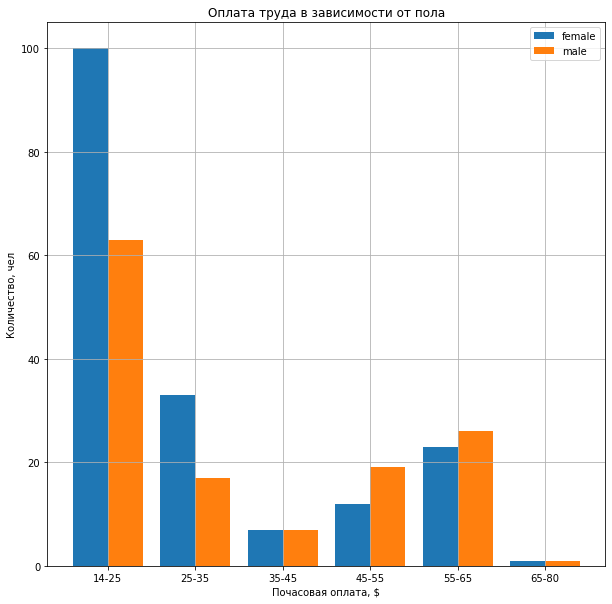

In [18]:
sex_t  = sex1.T
sex_t
#  Задаем смещение равное половине ширины прямоугольника:
x1 = np.arange(0, 6) - 0.2
x2 = np.arange(0, 6) + 0.2
fig, ax = plt.subplots()
ax.bar(x1, sex_t['Female'],width = 0.4)
ax.bar(x2, sex_t['Male'],width = 0.4)
plt.legend(['female','male'])
plt.title("Оплата труда в зависимости от пола")
ax.set_xlabel('Почасовая оплата, $')
ax.set_ylabel('Количество, чел')
plt.xticks(np.arange(0,6),sex_t.index)
plt.grid(True)
plt.show()

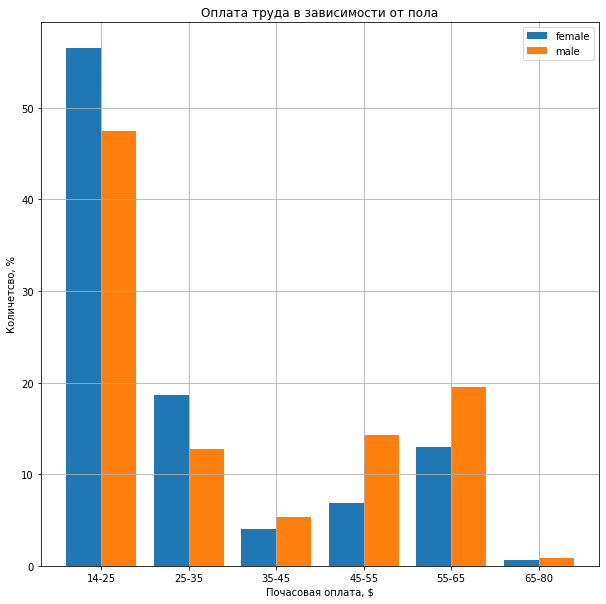

In [21]:
sex_t  = sex2.T
sex_t
#  Задаем смещение равное половине ширины прямоугольника:
x1 = np.arange(0, 6) - 0.2
x2 = np.arange(0, 6) + 0.2
fig, ax = plt.subplots()
ax.bar(x1, sex_t['Female'],width = 0.4)
ax.bar(x2, sex_t['Male'],width = 0.4)
plt.legend(['female','male'])
plt.title("Оплата труда в зависимости от пола")
ax.set_xlabel('Почасовая оплата, $')
ax.set_ylabel('Количетсво, %')
plt.xticks(np.arange(0,6),sex_t.index)
plt.grid(True)
plt.show()

Вывод: По полученным графикам видно что на работе с зарплатой (14-35) нанято большее количество женщин, при зарплате (35-45) равное количество женщин и мужчин; количество мужчин получающих зарплату (45-55) практически вдвое больше количества женщин,так же больше мужчин получают зарплату  (55-65). Учитывая тот факт, что при количестве женщин (177 чел.) и мужчин (133 чел.), работающих в организации, видно что на низкооплачиваемой работе работает больше женщин. Значит можно говорить, что величина зарплаты зависит от пола.

***2. Есть ли зависимость между уровнем увольнений и тем, под чьим руководством работали люди?***

In [3]:
reason_for_term = pd.read_sql_query('''select "Manager Name",
round(((sum(case WHEN "Reason For Term" = 'N/A - Has not started yet' then 0
           WHEN "Reason For Term" = 'N/A - still employed' then 0
           else 1 end)+0.0)/count("Employee Name"))*100) all_reasons,
round(((sum(case WHEN "Reason For Term" = 'attendance' then 1 else 0 end)+0.0)/count("Employee Name"))*100) attendance,
round(((sum(case WHEN "Reason For Term" = 'hours' then 1 else 0 end)+0.0)/count("Employee Name"))*100) hours,
round(((sum(case WHEN "Reason For Term" = 'career change' then 1 else 0 end)+0.0)/count("Employee Name"))*100) career_change,
round(((sum(case WHEN "Reason For Term" = 'unhappy' then 1 else 0 end)+0.0)/count("Employee Name"))*100) unhappy,
round(((sum(case WHEN "Reason For Term" = 'more money' then 1 else 0 end)+0.0)/count("Employee Name"))*100) more_money,
round(((sum(case WHEN "Reason For Term" = 'Another position' then 1 else 0 end)+0.0)/count("Employee Name"))*100) Another_position,
count("Employee Name") number_of_staff
from hr_dataset
group by "Manager Name"
order by all_reasons desc, career_change desc, unhappy desc, more_money desc, Another_position desc
;''', conn)
reason_for_term

,Manager Name,all_reasons,attendance,hours,career_change,unhappy,more_money,another_position,number_of_staff
0,Webster Butler,62.0,0.0,5.0,5.0,10.0,5.0,10.0,21
1,Amy Dunn,62.0,5.0,10.0,0.0,19.0,10.0,5.0,21
2,Kissy Sullivan,55.0,0.0,5.0,0.0,9.0,5.0,14.0,22
3,Simon Roup,47.0,0.0,12.0,6.0,0.0,0.0,6.0,17
4,Michael Albert,41.0,5.0,0.0,0.0,5.0,14.0,5.0,22
5,Elijiah Gray,36.0,0.0,5.0,9.0,5.0,0.0,9.0,22
6,Alex Sweetwater,33.0,11.0,0.0,0.0,0.0,0.0,11.0,9
7,Debra Houlihan,33.0,0.0,0.0,0.0,0.0,0.0,0.0,3
8,Janet King,32.0,5.0,0.0,5.0,5.0,0.0,11.0,19
9,Brannon Miller,29.0,0.0,0.0,5.0,10.0,5.0,5.0,21


Вывод: По полученным данным видно, что для части менеджеров характерен высокий процент увольнения людей работающих под их началом. Стоит отметить, что среди причин есть такие как финансовый вопрос, неудовлетворенность работой, чрезмерная загруженность(еслия правильно понял причину hours) и посещаемость. Данным менеджерам необходимо обратить внимание на существующие проблемы, чтобы уменьшить процент увольнений. Из всего этого следует, что зависимость между процентом уволившихся и менеджерами существует.

***3. Есть ли зависимость между расойсотрудника и его зарплатой?***

Определим расово-этнический состав орагнизации

In [4]:
df_races = pd.read_sql_query('''select racedesc, count(racedesc) , 
                                round(count(racedesc)*100./(select distinct count('Employee Name') from hr_dataset),2) as percent
                                from hr_dataset
                                group by racedesc
                                ;''', conn)
df_races

,racedesc,count,percent
0,American Indian or Alaska Native,4,1.29
1,Hispanic,4,1.29
2,Two or more races,18,5.81
3,Asian,34,10.97
4,White,193,62.26
5,Black or African American,57,18.39


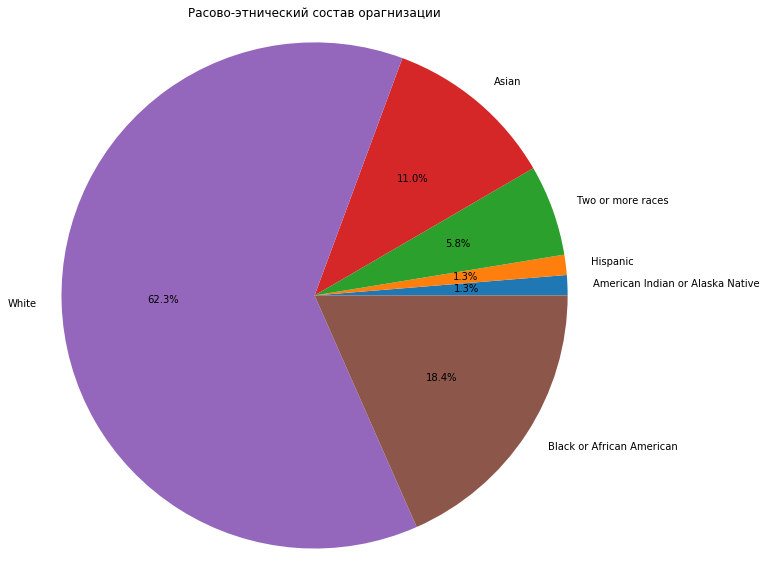

In [5]:
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(aspect="equal"))
ax.pie(df_races['percent'],labels=df_races['racedesc'],autopct='%1.1f%%')
ax.axis('equal')
ax.set_title("Расово-этнический состав орагнизации")
plt.show()

Рассмотрим три самые многочисленные расово-этнические группы:

In [33]:
df_pay_race1 = pd.read_sql_query('''select racedesc, count(racedesc),
count(CASE WHEN "Pay Rate">= 14 AND "Pay Rate" < 25 THEN 1 END) "14-25",
count(CASE WHEN "Pay Rate">= 25 AND "Pay Rate" < 35 THEN 1 END) "25-35",
count(CASE WHEN "Pay Rate">= 35 AND "Pay Rate" < 45 THEN 1 END) "35-45",
count(CASE WHEN "Pay Rate">= 45 AND "Pay Rate" < 55 THEN 1 END) "45-55",
count(CASE WHEN "Pay Rate">= 55 AND "Pay Rate" < 65 THEN 1 END) "55-65",
count(CASE WHEN "Pay Rate">= 65 AND "Pay Rate" < 80 THEN 1 END) "65-80"
from hr_dataset
group by racedesc
order by count desc
;''', conn)
df_pay_race1 = df_pay_race1.set_index('racedesc')
df_pay_race1  = df_pay_race1.head(3)
del df_pay_race1['count']
df_pay_race1

,14-25,25-35,35-45,45-55,55-65,65-80
racedesc,,,,,,
White,109,32,9,18,23,1
Black or African American,23,10,2,6,15,1
Asian,18,4,3,6,3,0


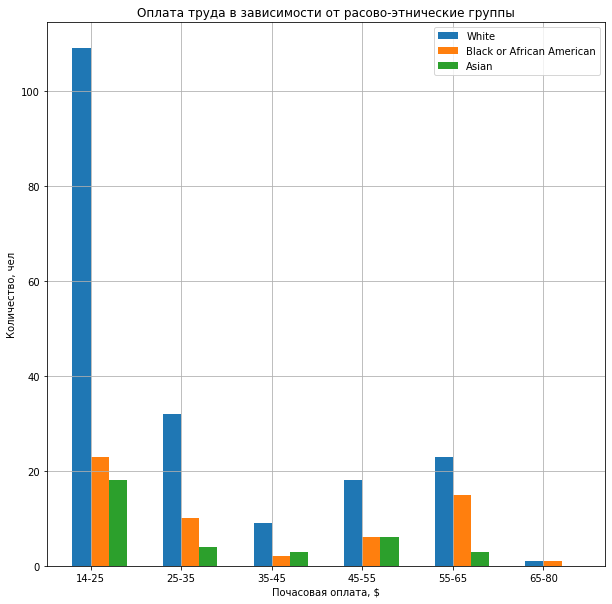

In [61]:
df_pay_race_t  = df_pay_race1.T
df_pay_race_t
x1 = np.arange(0, 6) - 0.1
x2 = np.arange(0, 6) + 0.1
x3 = np.arange(0, 6) + 0.3
fig, ax = plt.subplots()
ax.bar(x1, df_pay_race_t['White'],width = 0.2)
ax.bar(x2, df_pay_race_t['Black or African American'],width = 0.2)
ax.bar(x3, df_pay_race_t['Asian'],width = 0.2)
plt.legend(['White','Black or African American','Asian'])
plt.title("Оплата труда в зависимости от расово-этнические группы")
ax.set_xlabel('Почасовая оплата, $')
ax.set_ylabel('Количество, чел')
plt.xticks(np.arange(0,6),df_pay_race_t.index)
plt.grid(True)
plt.show()

In [50]:
df_pay_race2 = pd.read_sql_query('''select racedesc,count(racedesc),
round(((count(CASE WHEN "Pay Rate">= 14 AND "Pay Rate" < 25 THEN 1 END)+0.0)/count(racedesc))*100,1) "14-25",
round(((count(CASE WHEN "Pay Rate">= 25 AND "Pay Rate" < 35 THEN 1 END)+0.0)/count(racedesc))*100,1) "25-35",
round(((count(CASE WHEN "Pay Rate">= 35 AND "Pay Rate" < 45 THEN 1 END)+0.0)/count(racedesc))*100,1) "35-45",
round(((count(CASE WHEN "Pay Rate">= 45 AND "Pay Rate" < 55 THEN 1 END)+0.0)/count(racedesc))*100,1) "45-55",
round(((count(CASE WHEN "Pay Rate">= 55 AND "Pay Rate" < 65 THEN 1 END)+0.0)/count(racedesc))*100,1) "55-65",
round(((count(CASE WHEN "Pay Rate">= 65 AND "Pay Rate" < 80 THEN 1 END)+0.0)/count(racedesc))*100,1) "65-80"
from hr_dataset
group by racedesc 
order by count desc
;''', conn)
df_pay_race2 = df_pay_race2.set_index('racedesc')
df_pay_race2  = df_pay_race2.head(3)
del df_pay_race2['count']
df_pay_race2

,14-25,25-35,35-45,45-55,55-65,65-80
racedesc,,,,,,
White,56.5,16.6,4.7,9.3,11.9,0.5
Black or African American,40.4,17.5,3.5,10.5,26.3,1.8
Asian,52.9,11.8,8.8,17.6,8.8,0.0


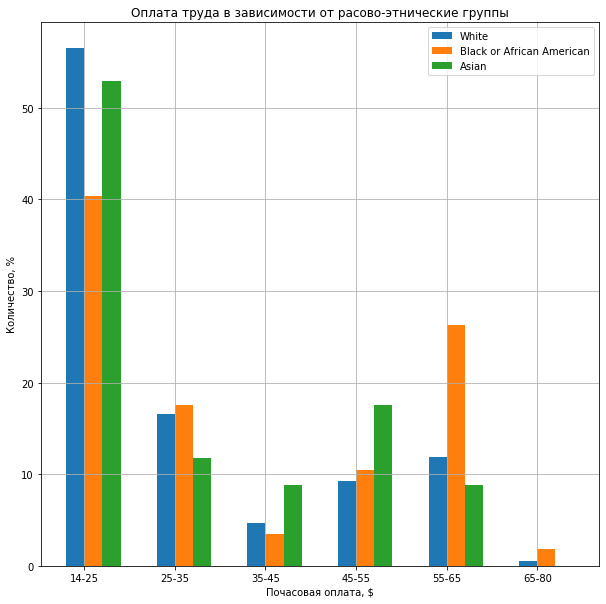

In [63]:
df_pay_race_t2  = df_pay_race2.T
df_pay_race_t2
x1 = np.arange(0, 6) - 0.1
x2 = np.arange(0, 6) + 0.1
x3 = np.arange(0, 6) + 0.3
fig, ax = plt.subplots()
ax.bar(x1, df_pay_race_t2['White'],width = 0.2)
ax.bar(x2, df_pay_race_t2['Black or African American'],width = 0.2)
ax.bar(x3, df_pay_race_t2['Asian'],width = 0.2)
plt.legend(['White','Black or African American','Asian'])
plt.title("Оплата труда в зависимости от расово-этнические группы")
ax.set_xlabel('Почасовая оплата, $')
ax.set_ylabel('Количество, %')
plt.xticks(np.arange(0,6),df_pay_race_t2.index)
plt.grid(True)
plt.show()

Вывод: На первый взгляд если посмотреть на график с общим количеством людей получающих ту или иную зарплату, то видно что белое население превалирует на всех уровнях зарплаты. Но если посмотреть на график показывающий процент сотрудников от общего количества людей их расово-этнической группы, то картина меняется.Так мы видим, что при ставке
14-25 - больше всего сотрудников белой и азиатской группы,
25-35 - примерное равенство белой и афроамериканской группы,
35-45, 45-55 - лидирует азиатская группа, количество сотрудников белой и афроамериканской групп меньше, 
55-65 - лидирует афроамериканская группа. 
В целом по полученным данным можно сделать вывод скорее об отсутствии расовых предубеждений в данной организации, чем об их наличии.

***4. Зависимость между продолжительностью работы в компании и performance_score***

In [45]:
df_exp = pd.read_sql_query('''select 
min(round(("Days Employed"+0.0)/365)) , avg(round(("Days Employed"+0.0)/365)),
median(round(("Days Employed"+0.0)/365)), max(round(("Days Employed"+0.0)/365))
from hr_dataset
;''', conn)
df_exp

,min,avg,median,max
0,0.0,3.535484,3.0,12.0


Медианная продолжительность работы в компании - 3 года, максимальная продолжительность - 12 лет.

In [84]:
df_exp = pd.read_sql_query('''select round(("Days Employed"+0.0)/365) work_exp,
count("Employee Name")
from hr_dataset
group by work_exp
order by work_exp
;''', conn)
df_exp

,work_exp,count
0,0.0,22
1,1.0,44
2,2.0,22
3,3.0,71
4,4.0,67
5,5.0,25
6,6.0,34
7,7.0,14
8,8.0,4
9,9.0,4


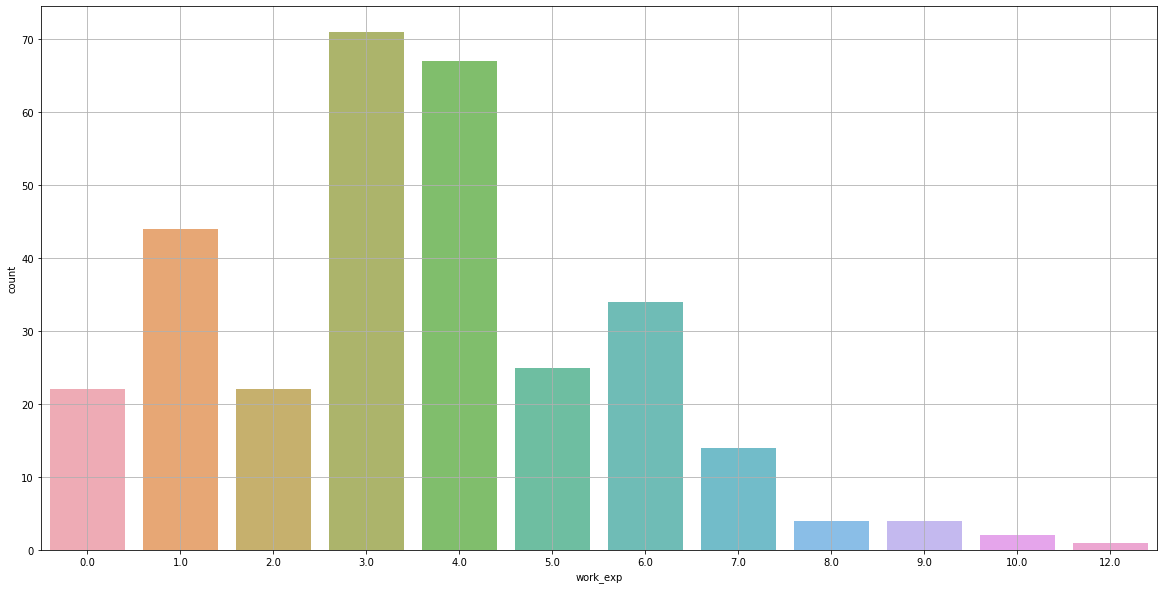

In [93]:
plt.figure(figsize=(20,10))
sns.barplot(x=df_exp['work_exp'], y=df_exp['count'], alpha=0.8)
plt.grid(True)
plt.show()

In [96]:
df_exp = pd.read_sql_query('''select round(("Days Employed"+0.0)/365) work_exp,
Sum(case WHEN "Performance Score" = '90-day meets' then 1 else 0 end) "90-day meets",
Sum(case WHEN "Performance Score" = 'PIP' then 1 else 0 end) "PIP",
Sum(case WHEN "Performance Score" = 'Needs Improvement' then 1 else 0 end) "Needs Improvement",
Sum(case WHEN "Performance Score" = 'Fully Meets' then 1 else 0 end) "Fully Meets",
Sum(case WHEN "Performance Score" = 'Exceeds' then 1 else 0 end) "Exceeds",
Sum(case WHEN "Performance Score" = 'Exceeds' then 1 else 0 end) "Exceptional",
Sum(case WHEN "Performance Score" = 'N/A- too early to review' then 1 else 0 end) "N/A- too early to review"
from hr_dataset
group by work_exp
order by work_exp;''', conn)
df_exp = df_exp.set_index('work_exp')
df_exp

,90-day meets,PIP,Needs Improvement,Fully Meets,Exceeds,Exceptional,N/A- too early to review
work_exp,,,,,,,
0.0,4,0,0,4,0,0,14
1.0,4,1,1,29,3,3,6
2.0,1,1,4,11,2,2,3
3.0,13,3,3,31,5,5,12
4.0,4,1,2,48,9,9,2
5.0,2,0,2,19,1,1,0
6.0,3,2,1,23,4,4,0
7.0,0,1,2,8,2,2,0
8.0,0,0,0,3,0,0,0


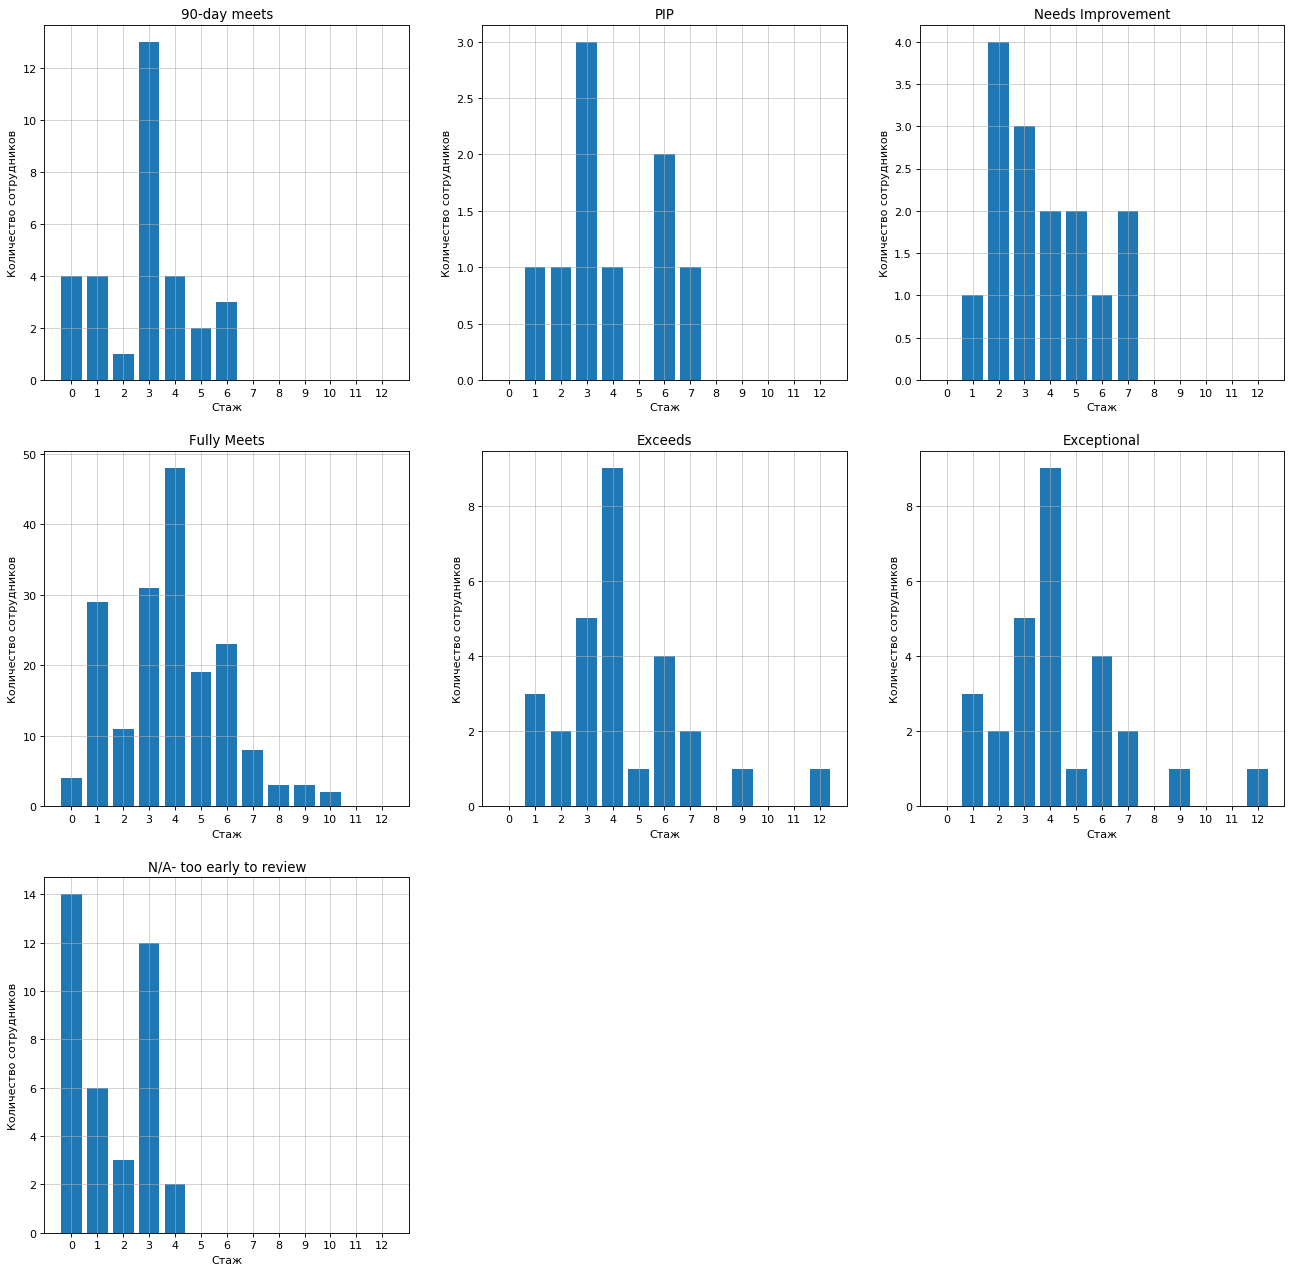

In [97]:
#Создаем сводную таблицу, для отрисовки графиков
fig = plt.figure(figsize=(20, 20), dpi=80)
for i,val in enumerate(df_exp):  
    ax = fig.add_subplot(3, 3, i+1)
    ax.bar(df_exp.index, df_exp[val])
    ax.set_xlabel('Стаж')
    ax.set_ylabel('Количество сотрудников')
    plt.xticks(np.arange(0,13))
    ax.grid(linewidth = 0.5 )
    plt.title(df_exp.columns[i])

Вывод: Из полученных данных видно, что наиболее проблемной является продолжительность 2-3 года, период максимальной эффективности сотрдуников - 4 года. Дальше наблюдается спад эффективности работы сотрудников.
Зависимость эффективности работы  от продолжительности работы сотрудника есть.